# Categorical VAE using VI with Mixture of Discrete Normalizing Flows

Design of the VAE follows the implementation from https://github.com/ericjang/gumbel-softmax

## Imports and Helper Functions

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfpd

import copy
import time
import pandas as pd

In [2]:
tf.__version__, tfp.__version__

('2.2.0', '0.9.0')

In [3]:
import sys
sys.path.append('../mdnf')

In [4]:
import aux
import flows_mixture
import flows_factorized
import base_mixtures
import base_constructors
import inference

## Configuration

In [5]:
# can be run as a script with args in format KEY=VAL,KEY=[STRVAL],...
args = aux.parse_script_args() 

In [6]:
SEED=args.get("SEED", 0)
OUT=args.get("OUT", "VAEFlows.csv")

# base distribution type (p -> delta)
# see create_base_mixture in base_constructors.py for options
BASE_SPECIFICATION = args.get("BASE_SPECIFICATION", "p") 

B = args.get("B", 40) # how many flows in mixture
N = args.get("N", 10) # how many latent variables
K = args.get("K", 2) # how many categories each

# Temperature hyperparameter
BASE_TEMP = args.get("BASE_TEMP", 100.0)
ANNEAL_RATE = args.get("ANNEAL_RATE", 0.00003)
MIN_TEMP = args.get("MIN_TEMP", 0.001)

OPTIMIZER = args.get("OPTIMIZER", "ADAM")
LR = args.get("LR", 0.001)
BATCH_SIZE=args.get("BATCH_SIZE", 256) # how many samples in minibatch
NUM_ITERS=args.get("NUM_ITERS", 100) # how many epochs

NSAMPLES = args.get("NSAMPLES", 1) # how many samples per data point in each step (=how many ELBOs evaluations)

In [7]:
CFG = ["VAE_FLOWS", SEED, OUT, B, N, K, BATCH_SIZE, NUM_ITERS, 
       BASE_TEMP, None, OPTIMIZER, LR, ANNEAL_RATE, MIN_TEMP]
print("CFG=%s" % CFG)

CFG=['VAE_FLOWS', 0, 'VAEFlows.csv', 40, 10, 2, 256, 100, 100.0, None, 'ADAM', 0.001, 3e-05, 0.001]


## Approximiation: bases & flows

In [8]:
base = base_constructors.create_categorical_blocks(N, K, B, BASE_SPECIFICATION, 
                                          independent_variables=True); 
print("base = %s" % base)

base = <class 'base_mixtures.FactorizedIndependentCategoricalMixture'>(N=10 (#dims), B=40 (#components), K=2 (#categories) mixing_probs=tf.Tensor(
[0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025
 0.025 0.025 0.0...)


In [9]:
temperature = tf.Variable(BASE_TEMP, name="temperature") #!

flows = [flows_factorized.DiscreteFactorizedFlow(N, K, temperature=temperature) for _ in range(B)]
mixture = flows_mixture.DiscreteFlowsMixture(N, K, B, flows=flows)

## Inference

In [10]:
OPTIMIZERS = {"RMS": tf.keras.optimizers.RMSprop,
              "ADAM": tf.keras.optimizers.Adam}
if OPTIMIZER not in OPTIMIZERS: raise ValueError("Unknown optimizer!")
optimizer_class = OPTIMIZERS[OPTIMIZER]
optimizer = optimizer_class(learning_rate=LR)

print("optimizer=%s lr=%s" % (optimizer, LR))

optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fe338b61e50> lr=0.001


## Model

In [11]:
class CategoricalVAE(tf.Module):

    def __init__(self, base, mixture, N, K, name=None):
        """
        
            Args:
                N  number of variables
                K  number of categories for each variable
                B  number of components in a mixture of flows
        """
        super(CategoricalVAE, self).__init__(name=name)
        
        self.base = base
        self.mixture = mixture

        self.N = N # number of categorical distributions
        self.K = K # number of classes
        
        
        self.calc_logits_z = tf.keras.Sequential([ # encoder
                                             tf.keras.layers.Flatten(name="encoder0"),
                                             tf.keras.layers.Dense(512, activation="relu", 
                                                                   input_shape=(None, 784), name="encoder1"),
                                             tf.keras.layers.Dense(256, activation="relu", name="encoder2"),
                                             tf.keras.layers.Dense(K*N, activation=None, name="encoder3"),
                                             tf.keras.layers.Reshape( [N,K] , name="encoder4")
                                            ], name="encoder")

        self.calc_logits_x = tf.keras.Sequential( # decoder
                                            [tf.keras.layers.Flatten(name="decoder0"),
                                             tf.keras.layers.Dense(256, activation="relu", name="decoder1"),
                                             tf.keras.layers.Dense(512, activation="relu", name="decoder2"),
                                             tf.keras.layers.Dense(784, activation=None, name="decoder3"),
                                            ], name="decoder")         
        
        B = len(mixture.flows)
        self.calc_logits_flows = tf.keras.Sequential([ 
                                             tf.keras.layers.Flatten(name="flows0"),
                                             tf.keras.layers.Dense(K*N*B, activation="relu", 
                                                                   input_shape=(None, 784), name="flows1"),
                                             tf.keras.layers.Dense(K*N*B, activation=None, name="flows2"),
                                             tf.keras.layers.Reshape( [B,N,K] , name="flows3")
                                            ], name="logits_flows")        
        
    def __call__(self, x):       
        # variational posterior q(z|x), i.e. the encoder 
        # unnormalized logits for N separate K-categorical distributions (shape=(batch_size,N,K))                
        logits_z = self.calc_logits_z(x)                
                
        # sample from base
        samples_ext, mask = self.base.sample_extm(logits_z.shape[0])
        
        # shuffle with flows controled by transformed logits
        logits_flows = self.calc_logits_flows(logits_z)
        for i, flow in enumerate(self.mixture.flows):
            #flow.logits = logits_z
            flow.logits = logits_flows[:,i,...]
        samples = self.mixture(samples_ext, mask)                  
        
        # generative model p(x|z)
        logits_x = self.calc_logits_x(samples)    
        p_x = tfpd.Bernoulli(logits=logits_x)
        
        return p_x, samples
    
    def log_prob(self, samples): # for entropy/KL evaluation
        samples_inv = self.mixture.reverse(samples)
        return self.base.log_prob_ext(samples_inv) # independent!
    
    @property
    def temperature(self):
        return self.mixture.temperature
    
    @temperature.setter
    def temperature(self, value):
        self.mixture.temperature = value
    

## Training

In [12]:
# get data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path='mnist.npz')
frmt = lambda images: tf.cast(tf.reshape(images,(-1, 784)), tf.float32)/255.0
x_train, x_test = frmt(x_train), frmt(x_test)

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

In [13]:
def loss_MC(x, p_x, vae, samples): 
    """
        Args:
            samples  Samples from latent representation
    """
    batch_size, N, K = samples.shape
    
    KL = vae.log_prob(samples) - tf.reduce_sum(samples*np.log(1./K), [-1,-2])

    lik = tf.reduce_sum(p_x.log_prob(x), -1) # sums over 784 pixels
    
    #print("lik=%.4f KL=%.4f prior=%.4f entropy_q=%.4f" % 
    #      ( tf.reduce_mean(lik), tf.reduce_mean(KL), tf.reduce_mean(prior_samples), tf.reduce_mean(entropy_q)))
    return tf.reduce_mean(lik), tf.reduce_mean(KL) 

In [14]:
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [15]:
vae = CategoricalVAE(base, mixture, N, K)
loss = loss_MC
results = []
best_loss, best_vae = float("inf"), None
i = 0

In [16]:
def true_loss(x, p_x, vae, nsamples=1000, *args):
    """ Estimate negative ELBO from samples. 
        
        Used only as a sanity check.
        Computationally extremely expensive.
    """
    batch_size,N,K = x.shape[0], vae.N, vae.K
    
    # sampling:
    ss = []
    self = vae
    logits_z = self.calc_logits_z(x)                
    for _ in range(nsamples):
                
        # sample from base
        samples_ext, mask = self.base.sample_extm(logits_z.shape[0])
        # shuffle with flows controled by transformed logits
        logits_flows = self.calc_logits_flows(logits_z)
        for i, flow in enumerate(self.mixture.flows):
            #flow.logits = logits_z
            flow.logits = logits_flows[:,i,...]
        samples = self.mixture(samples_ext, mask)
        ss.append(samples)
       
    py = tf.reduce_mean(tf.stack(ss), 0)
    H_q = -tf.reduce_sum(py*np.log(py+1e-16), [-1,-2]) # sum over categories and then over independent variables

    Eq_logp = np.sum(np.mean(np.ones((batch_size,N,K))*np.log(1/K), -1), -1)

    KL = -Eq_logp -H_q
    Eq_logp = float(tf.reduce_mean(Eq_logp))
    H_q = float(tf.reduce_mean(H_q))
    KL = float(tf.reduce_mean(KL))
    lik = tf.reduce_sum(p_x.log_prob(x), -1)
    lik = float(tf.reduce_mean(lik))
    return -(lik-KL), lik, KL, Eq_logp, H_q

In [17]:
def _eval_elbo_from_samples_(e):
    if not (e<0 or e==NUM_ITERS-1 or e==0):
        tl, true_lik, true_KL = float("inf"), float("-inf"), float("inf")
        true_Eq_logp, true_H_q = float("nan"), float("nan")        
        return tl, true_lik, true_KL, true_Eq_logp, true_H_q
    
    nbatches = len(x_train)/BATCH_SIZE
    how_many_batches = max( 100 / ((N*K)/10), 20 )
    #how_many_batches = 3 
    p_keep = how_many_batches / nbatches

    print("[%.1fs] epoch=%i/iteration=%i: evaluating ELBO from samples on around %d batches..." % 
          (time.time()-start, e, i, int(p_keep*nbatches)))
    
    true_losses = []
    true_liks, true_KLs, true_Eq_logps, true_H_qs = [], [], [], []  
    train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE, drop_remainder=True)
    for batch_no, (batch_x, labels) in enumerate(train_ds):
        p_x, samples = vae(batch_x)
        if (np.random.uniform()<p_keep):
            tl, true_lik, true_KL, true_Eq_logp, true_H_q = true_loss(batch_x, p_x, vae)
            true_losses.append(tl)
            true_liks.append(true_lik); true_KLs.append(true_KL); 
            true_Eq_logps.append(true_Eq_logp); true_H_qs.append(true_H_q);
            print("[%.2f]  batch_ix=%d. > ELBO=%.2f lik=%.2f KL=%.2f Eqlogp=%.2f Hq=%.2f" % (
                  time.time()-start, batch_no, -tl, true_lik, true_KL, true_Eq_logp, true_H_q))
            sys.stdout.flush()
            
    tl, true_lik, true_KL, true_Eq_logp, true_H_q = \
        np.mean(true_losses), np.mean(true_liks), np.mean(true_KLs), np.mean(true_Eq_logps), np.mean(true_H_qs)
    print("[%.2f] (avg from %d) > ELBO=%.2f lik=%.2f KL=%.2f Eqlogp=%.2f Hq=%.2f" % (
            time.time()-start, len(true_losses), -tl, true_lik, true_KL, true_Eq_logp, true_H_q))
    sys.stdout.flush()
        
    return tl, true_lik, true_KL, true_Eq_logp, true_H_q

In [18]:
start = time.time()
for e in range(NUM_ITERS):

    losses, liks, kls = [], [], []
    for batch_x, labels in train_ds:
        
        with tf.GradientTape() as tape:              
            l = 0.
            for _ in range(NSAMPLES):
                p_x, samples = vae(batch_x)                       
                lik, KL = loss(batch_x, p_x, vae, samples)  
                l += -(lik-KL)                
            l /= NSAMPLES;             
            lik /= NSAMPLES; KL /= NSAMPLES
            losses.append(float(l)); liks.append(float(lik)); kls.append(float(KL));             

        g = tape.gradient(l, list(vae.trainable_variables))
        optimizer.apply_gradients(zip(g, list(vae.trainable_variables)))
        vae.temperature = np.maximum(BASE_TEMP*np.exp(-ANNEAL_RATE*i), MIN_TEMP) 
                                   
        if i%100==0: 
            tl, true_lik, true_KL, true_Eq_logp, true_H_q = true_loss(batch_x, p_x, vae)
            
            print("[%.1fs] epoch=%i/iteration=%i loss=%.2f ELBO=%.2f (lik=%.2f kl=%.2f Eqlogp=%.2f Hq=%.2f)" % \
                           (time.time()-start, e, i, l, 
                            -tl, true_lik, true_KL, true_Eq_logp, true_H_q))
        i += 1
                      
    ########################################################################    
    if np.mean(losses)<best_loss:
        best_loss = np.mean(losses)
        try: 
            best_vae = copy.deepcopy(vae)
        except Exception as exc:
            if best_vae is None:
                    print("[ERROR] Failed to copy VAE object as best_vae: %s" % exc)
            best_vae = vae    
    ########################################################################            
            
    tl, true_lik, true_KL, true_Eq_logp, true_H_q = _eval_elbo_from_samples_(e)            
    print ("[%.1fs] epoch=%d. l=%.2f (best=%.2f) lik=%.2f kl=%.2f t=%.2f ELBO~=%.2f=%.2f-%.2f" % (
            time.time()-start, e, 
            np.mean(losses), best_loss, np.mean(liks), np.mean(kls),
            vae.temperature, -tl, true_lik, true_KL))
    results.append(CFG+[time.time()-start, 
                e, np.mean(losses), best_loss, tl, vae.temperature,
                true_lik, true_KL, true_Eq_logp, true_H_q, 
                np.mean(liks), np.mean(kls)])
    sys.stdout.flush()
    
    print("Saving to %s" % OUT)
    pd.DataFrame(results).to_csv(OUT, header=False, index=False)    

[69.1s] epoch=0/iteration=0 loss=545.56 ELBO=-545.61 (lik=-545.44 kl=0.17 Eqlogp=-6.93 Hq=6.76)
[167.1s] epoch=0/iteration=100 loss=201.84 ELBO=-201.88 (lik=-201.77 kl=0.11 Eqlogp=-6.93 Hq=6.82)
[262.4s] epoch=0/iteration=200 loss=214.03 ELBO=-214.07 (lik=-211.91 kl=2.16 Eqlogp=-6.93 Hq=4.77)
[273.5s] epoch=0/iteration=235: evaluating ELBO from samples on around 3 batches...
[342.92]  batch_ix=99. > ELBO=-204.64 lik=-203.06 KL=1.58 Eqlogp=-6.93 Hq=5.35
[409.79]  batch_ix=166. > ELBO=-208.70 lik=-206.96 KL=1.75 Eqlogp=-6.93 Hq=5.19
[414.70] (avg from 2) > ELBO=-206.67 lik=-205.01 KL=1.66 Eqlogp=-6.93 Hq=5.27
[414.7s] epoch=0. l=218.49 (best=218.49) lik=-217.69 kl=0.80 t=99.30 ELBO~=-206.67=-205.01-1.66
Saving to VAEFlows.csv
[498.3s] epoch=1/iteration=300 loss=196.15 ELBO=-196.14 (lik=-195.02 kl=1.13 Eqlogp=-6.93 Hq=5.80)
[593.6s] epoch=1/iteration=400 loss=196.98 ELBO=-197.07 (lik=-195.61 kl=1.46 Eqlogp=-6.93 Hq=5.47)
[616.6s] epoch=1. l=193.15 (best=193.15) lik=-191.87 kl=1.28 t=98.60

[5394.9s] epoch=22/iteration=5400 loss=138.80 ELBO=-139.00 (lik=-134.10 kl=4.90 Eqlogp=-6.93 Hq=2.04)
[5396.0s] epoch=22. l=149.07 (best=149.07) lik=-144.60 kl=4.47 t=85.03 ELBO~=-inf=-inf-inf
Saving to VAEFlows.csv
[5476.2s] epoch=23/iteration=5500 loss=147.86 ELBO=-147.89 (lik=-143.30 kl=4.59 Eqlogp=-6.93 Hq=2.34)
[5557.1s] epoch=23/iteration=5600 loss=139.88 ELBO=-140.19 (lik=-135.94 kl=4.25 Eqlogp=-6.93 Hq=2.68)
[5567.7s] epoch=23. l=148.24 (best=148.24) lik=-143.71 kl=4.53 t=84.44 ELBO~=-inf=-inf-inf
Saving to VAEFlows.csv
[5638.1s] epoch=24/iteration=5700 loss=144.60 ELBO=-144.57 (lik=-139.87 kl=4.70 Eqlogp=-6.93 Hq=2.24)
[5718.8s] epoch=24/iteration=5800 loss=148.20 ELBO=-148.10 (lik=-143.62 kl=4.48 Eqlogp=-6.93 Hq=2.45)
[5739.1s] epoch=24. l=147.66 (best=147.66) lik=-143.11 kl=4.56 t=83.84 ELBO~=-inf=-inf-inf
Saving to VAEFlows.csv
[5800.0s] epoch=25/iteration=5900 loss=137.97 ELBO=-137.96 (lik=-133.37 kl=4.59 Eqlogp=-6.93 Hq=2.34)
[5880.9s] epoch=25/iteration=6000 loss=152.07 

[12222.5s] epoch=45. l=144.87 (best=144.58) lik=-140.15 kl=4.72 t=72.31 ELBO~=-inf=-inf-inf
Saving to VAEFlows.csv
[12303.6s] epoch=46/iteration=10900 loss=146.67 ELBO=-146.76 (lik=-142.06 kl=4.70 Eqlogp=-6.93 Hq=2.23)
[12386.9s] epoch=46/iteration=11000 loss=145.64 ELBO=-145.60 (lik=-140.84 kl=4.76 Eqlogp=-6.93 Hq=2.17)
[12399.2s] epoch=46. l=144.80 (best=144.58) lik=-140.09 kl=4.71 t=71.80 ELBO~=-inf=-inf-inf
Saving to VAEFlows.csv
[12468.7s] epoch=47/iteration=11100 loss=155.26 ELBO=-155.07 (lik=-150.36 kl=4.72 Eqlogp=-6.93 Hq=2.22)
[12550.2s] epoch=47/iteration=11200 loss=149.24 ELBO=-148.98 (lik=-144.23 kl=4.75 Eqlogp=-6.93 Hq=2.18)
[12571.9s] epoch=47. l=144.91 (best=144.58) lik=-140.21 kl=4.70 t=71.29 ELBO~=-inf=-inf-inf
Saving to VAEFlows.csv
[12632.0s] epoch=48/iteration=11300 loss=147.87 ELBO=-147.95 (lik=-143.12 kl=4.83 Eqlogp=-6.93 Hq=2.10)
[12714.0s] epoch=48/iteration=11400 loss=139.44 ELBO=-139.37 (lik=-134.78 kl=4.59 Eqlogp=-6.93 Hq=2.34)
[12796.7s] epoch=48/iteration=1

KeyboardInterrupt: 

In [19]:
vae_converged = vae
vae = best_vae

In [20]:
    # Append results for the best fit    
    e = -1
    tl, true_lik, true_KL, true_Eq_logp, true_H_q = _eval_elbo_from_samples_(e)    
    print ("[%.1fs] %d. l=%.2f (best=%.2f) lik=%.2f kl=%.2f t=%.2f ELBO~=%.2f=%.2f-%.2f" % (
            time.time()-start, e, 
            np.mean(losses), best_loss, np.mean(liks), np.mean(kls),
            vae.temperature, -tl, true_lik, true_KL))
    results.append(CFG+[time.time()-start, 
                e, np.mean(losses), best_loss, tl, vae.temperature,
                true_lik, true_KL, true_Eq_logp, true_H_q, 
                np.mean(liks), np.mean(kls)])
    sys.stdout.flush()
    
    print("Saving to %s" % OUT)
    pd.DataFrame(results).to_csv(OUT, header=False, index=False)

[14431.7s] epoch=-1/iteration=13500: evaluating ELBO from samples on around 3 batches...
[14493.25]  batch_ix=75. > ELBO=-151.86 lik=-147.10 KL=4.76 Eqlogp=-6.93 Hq=2.17
[14558.38]  batch_ix=183. > ELBO=-141.43 lik=-136.65 KL=4.78 Eqlogp=-6.93 Hq=2.15
[14561.49] (avg from 2) > ELBO=-146.64 lik=-141.87 KL=4.77 Eqlogp=-6.93 Hq=2.16
[14561.5s] -1. l=144.95 (best=144.58) lik=-140.32 kl=4.63 t=74.37 ELBO~=-146.64=-141.87-4.77
Saving to VAEFlows.csv


## reconstruction mean

In [21]:
import matplotlib.animation as animation
from matplotlib import pyplot as plt

In [22]:
np_x1 = x_train[-BATCH_SIZE:]
p_x, samples = vae(np_x1)

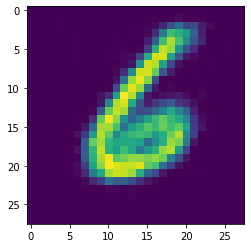

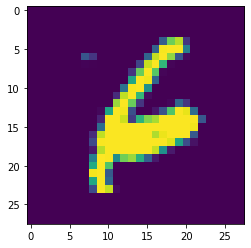

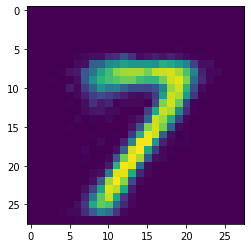

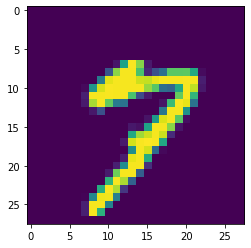

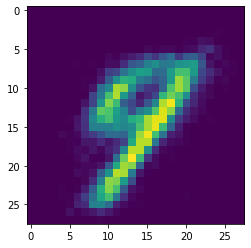

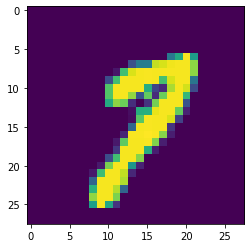

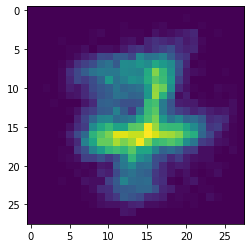

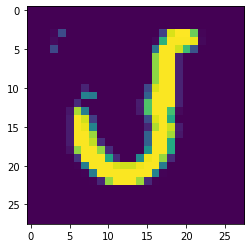

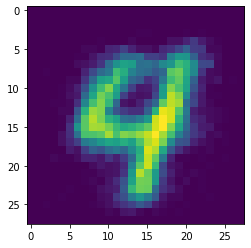

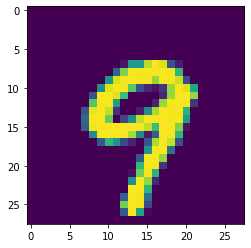

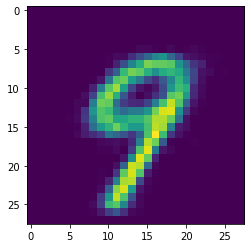

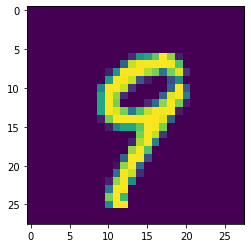

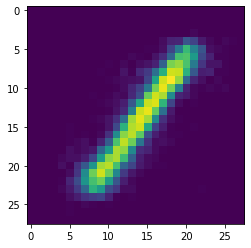

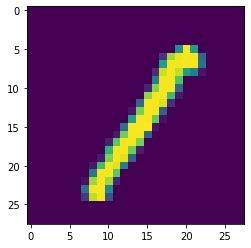

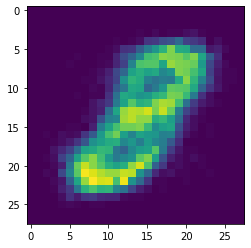

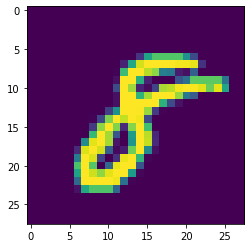

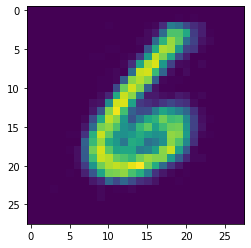

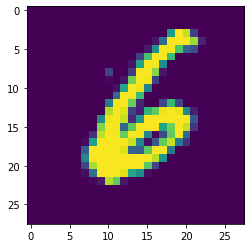

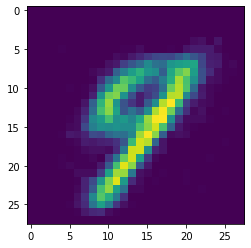

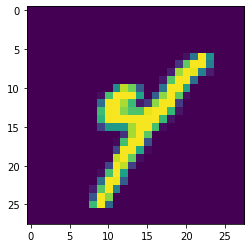

In [23]:
for data_pt_no in range(10):
    plt.imshow(np.mean(p_x[data_pt_no].sample(100),0).reshape((28,28))); plt.show()
    plt.imshow(np_x1[data_pt_no].numpy().reshape((28,28))); plt.show()

## Unconditional Generation

This consists of sampling from the prior $p_\theta(y)$ and passing it through the generative model.

In [24]:
batch, N, K = samples.shape

In [25]:
M=100*N
np_y = np.zeros((M,K))
np_y[range(M),np.random.choice(K,M)] = 1
np_y = np.reshape(np_y,[100,N,K])

In [26]:
logits_x = vae.calc_logits_x(tf.constant(np_y, dtype=tf.float32)) 
p_x = tfp.distributions.Bernoulli(logits=logits_x)
np_x = p_x.mean().numpy()

In [27]:
np_y = np_y.reshape((10,10,N,K))
np_y = np.concatenate(np.split(np_y,10,axis=0),axis=3)
np_y = np.concatenate(np.split(np_y,10,axis=1),axis=2)
y_img = np.squeeze(np_y)

In [28]:
np_x = np_x.reshape((10,10,28,28))
# split into 10 (1,10,28,28) images, concat along columns -> 1,10,28,280
np_x = np.concatenate(np.split(np_x,10,axis=0),axis=3)
# split into 10 (1,1,28,280) images, concat along rows -> 1,1,280,280
np_x = np.concatenate(np.split(np_x,10,axis=1),axis=2)
x_img = np.squeeze(np_x)

Text(0.5, 1.0, 'Generated Images')

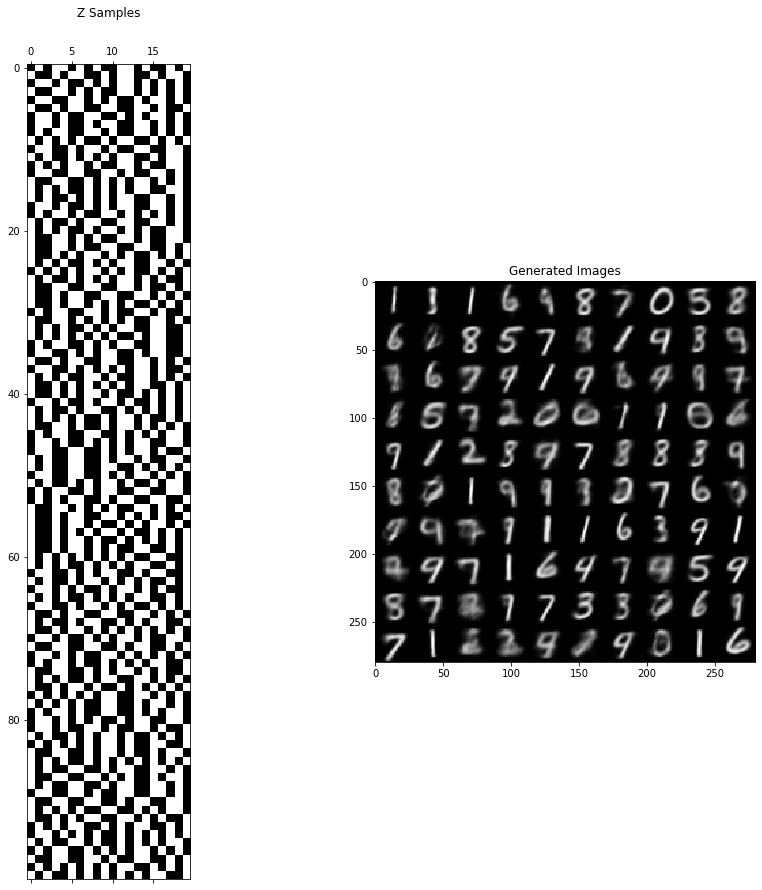

In [29]:
f,axarr=plt.subplots(1,2,figsize=(15,15))
# samples
axarr[0].matshow(y_img,cmap=plt.cm.gray)
axarr[0].set_title('Z Samples')
# reconstruction
axarr[1].imshow(x_img,cmap=plt.cm.gray,interpolation='none')
axarr[1].set_title('Generated Images')

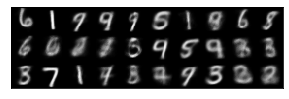

In [30]:
np.random.seed(123)
ys = []
for _ in range(3):
    xs = []
    for _ in range(10):
        np_y = np.zeros((N,K))
        np_y[range(N),np.random.choice(K,N)] = 1
        np_y = np.reshape(np_y,[1,N,K])

        logits_x = vae.calc_logits_x(tf.constant(np_y, dtype=tf.float32)) 
        p_x = tfp.distributions.Bernoulli(logits=logits_x)
        np_x = p_x.mean().numpy()[0].reshape((28,28))
        xs.append(np_x)
    ys.append(np.hstack(xs))
img = np.vstack(ys)   

fig = plt.figure(figsize=(6.4, 1.5), dpi=72)
plt.imshow(img, cmap=plt.cm.gray,interpolation='none')
plt.xticks([],{})
plt.yticks([],{})
plt.savefig("vae_flows.pdf", bbox_inches = 'tight', pad_inches =0)